
# **CLPS 1291 Final Project**



In [ ]:
#@title Enter your details - {display-mode: "form"}

Name = 'Yunxi Liang'  #@param {type: "string"}
Collaborators = ''  #@param {type: "string"}



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim import Adam

### FA Module Setup

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable


class LinearFANetwork(nn.Module):
    """
    Linear feed-forward networks with feedback alignment learning
    Does NOT perform non-linear activation after each layer
    """
    def __init__(self, in_features, num_layers, num_hidden_list):
        """
        :param in_features: dimension of input features (784 for MNIST)
        :param num_layers: number of layers for feed-forward net
        :param num_hidden_list: list of integers indicating hidden nodes of each layer = output features?
        """
        super(LinearFANetwork, self).__init__()
        self.in_features = in_features
        self.num_layers = num_layers
        self.num_hidden_list = num_hidden_list

        # create list of linear layers
        # first hidden layer
        self.linear = [LinearFAModule(self.in_features, self.num_hidden_list[0])] # calls FA module to build hidden layers
        # append additional hidden layers to list
        for idx in range(self.num_layers - 1):
            self.linear.append(LinearFAModule(self.num_hidden_list[idx], self.num_hidden_list[idx+1]))

        # create ModuleList to make list of layers work
        self.linear = nn.ModuleList(self.linear)

    def forward(self, inputs):
        """
        forward pass, which is same for conventional feed-forward net
        :param inputs: inputs with shape [batch_size, in_features]
        :return: logit outputs from the network
        """

        # first layer
        linear1 = self.linear[0](inputs)

        # second layer
        linear2 = self.linear[1](linear1)

        return linear2

class LinearFAModule(nn.Module):

    def __init__(self, input_features, output_features, bias=True):
        super(LinearFAModule, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # weight and bias for forward pass
        # weight has transposed form; more efficient (so i heard) (transposed at forward pass)
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            self.register_parameter('bias', None)

        # fixed random weight and bias for FA backward pass
        # does not need gradient
        self.weight_fa = Variable(torch.FloatTensor(output_features, input_features), requires_grad=False)

        # weight initialization
        torch.nn.init.kaiming_uniform(self.weight)
        torch.nn.init.kaiming_uniform(self.weight_fa)
        torch.nn.init.constant(self.bias, 1)

    def forward(self, input):
        return LinearFAFunction.apply(input, self.weight, self.weight_fa, self.bias)


class LinearFAFunction(autograd.Function): # is this like the relu activation function?

    @staticmethod
    # same as reference linear function, but with additional fa tensor for backward
    def forward(context, input, weight, weight_fa, bias=None):
        context.save_for_backward(input, weight, weight_fa, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    @staticmethod
    def backward(context, grad_output):
        input, weight, weight_fa, bias = context.saved_variables
        grad_input = grad_weight = grad_weight_fa = grad_bias = None

        if context.needs_input_grad[0]:
            # all of the logic of FA resides in this one line
            # calculate the gradient of input with fixed fa tensor, rather than the "correct" model weight
            grad_input = grad_output.mm(weight_fa.to(grad_output.device))
        if context.needs_input_grad[1]:
            # grad for weight with FA'ed grad_output from downstream layer
            # it is same with original linear function
            grad_weight = grad_output.t().mm(input)
        if bias is not None and context.needs_input_grad[3]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_weight_fa, grad_bias

### Processing data and training

In [ ]:
# SETUP and load the datasets
import os
import torch
import tensorflow_datasets as datasets
from torchvision import transforms
import torchvision

# check whether CUDA is available
cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available")
else:
    print("CUDA is not available")

# CIFAR-10 consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to the range [-1, 1]
])




CUDA is available


In [ ]:
'''
def load_cifar10(batch_size):
    DOWNLOAD_CIFAR10 = False
    if not(os.path.exists('./cifar10/')) or not os.listdir('./cifar10/'):
        DOWNLOAD_CIFAR10 = True

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  #for each RGB channel.
    ])

    train_data = torchvision.datasets.CIFAR10(
        root='./cifar10/', train=True,
        download=DOWNLOAD_CIFAR10, transform=transform
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    test_data = torchvision.datasets.CIFAR10(
        root='./cifar10/', train=False,
        download=DOWNLOAD_CIFAR10, transform=transform
    )
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader,test_loader = load_cifar10(64)
'''

100%|██████████| 170498071/170498071 [00:05<00:00, 30406874.84it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10/
Files already downloaded and verified


In [ ]:
# Download and load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for training data
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download and load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for test data
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 61505351.94it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108060387.00it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21288181.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19439315.07it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Baseline1: Build the Network: simple Con


In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        # reshape the data first to pass into conv1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # first conv layer (1->10)
        # maxpool2d (kernel=2), and then apply relu
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# second conv layer
        self.conv2_drop = nn.Dropout2d() # dropout layer
        # apply maxpool2d(kernel=2) after dropout, then apply relu
        # flatten tensor using view, prepare for fc
        self.fc1 = nn.Linear(320, 50) # fc1
        # apply relu again, and then dropout for regularization
        self.fc2 = nn.Linear(50, out_features) # fc2
        # pass this through softmax

    def forward(self, x):
        x = x.view(len(x), 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


In [ ]:
# Train Simple CNN
import torch.optim as optim
SimpleConvNet_model = SimpleConvNet(10)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(SimpleConvNet_model.parameters(), lr=0.01) # used sgd as optimizer

In [ ]:
epochs = 5
for epoch in range(epochs):
  for batch_id, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = SimpleConvNet_model(data)
    loss = criterion(output, target) # criterion ouptut a loss item
    loss.backward()
    optimizer.step()

    if batch_id % 100 ==0:
      print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss.item()))

SimpleConvNet_model.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = SimpleConvNet_model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset) # returns average test loss
accuracy = correct / len(test_loader.dataset)

print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, len(test_loader.dataset), 100. * accuracy))

RuntimeError: ignored

### Baseline2: Test if loaded weights are working

In [ ]:
# Weight extraction
trained_model = SimpleConvNet_model
state_dict = trained_model.state_dict()
conv1_weights = state_dict['conv1.weight']
conv2_weights = state_dict['conv2.weight']

In [ ]:
from torch.nn import Parameter
class SimpleCNN(nn.Module):
    def __init__(self, out_features, conv1_weights, conv2_weights):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1.weight = Parameter(conv1_weights)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2.weight = Parameter(conv2_weights)
        self.conv2_drop = nn.Dropout2d()
        # freeze the above 3 layers
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
        self.conv2_drop.requires_grad = False

        self.fc1 = nn.Linear(320, 50) # fc1
        # apply relu again, and then dropout for regularization
        self.fc2 = nn.Linear(50, out_features) # fc2
        # pass this through softmax

    def forward(self, x):
        x = x.view(len(x), 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

just_conv = SimpleCNN(10, conv1_weights, conv2_weights)
optimizer_cnn = torch.optim.SGD(just_conv.parameters(),
                            lr=0.01)

In [ ]:
epochs = 5
for epoch in range(epochs):
    for batch_id, (inputs, targets) in enumerate(train_loader):
        optimizer_cnn.zero_grad()
        outputs_cnn = just_conv(inputs)
        #print(inputs.shape, targets.shape, outputs_fa.shape)
        # calculate loss
        loss_cnn = criterion(outputs_cnn, targets)
        loss_cnn.backward()
        optimizer_cnn.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss_cnn.item()))

just_conv.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = just_conv(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset) # returns average test loss
accuracy = correct / len(test_loader.dataset)

print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, len(test_loader.dataset), 100. * accuracy))

Epoch 0, Batch 0, Loss: 2.5834
Epoch 0, Batch 100, Loss: 1.1622
Epoch 0, Batch 200, Loss: 0.9284
Epoch 0, Batch 300, Loss: 0.8592
Epoch 0, Batch 400, Loss: 0.5966
Epoch 0, Batch 500, Loss: 0.7824
Epoch 0, Batch 600, Loss: 0.6595
Epoch 0, Batch 700, Loss: 0.3930
Epoch 0, Batch 800, Loss: 0.3622
Epoch 0, Batch 900, Loss: 0.3888
Epoch 1, Batch 0, Loss: 0.4752
Epoch 1, Batch 100, Loss: 0.2869
Epoch 1, Batch 200, Loss: 0.4019
Epoch 1, Batch 300, Loss: 0.2408
Epoch 1, Batch 400, Loss: 0.1853
Epoch 1, Batch 500, Loss: 0.2997
Epoch 1, Batch 600, Loss: 0.4690
Epoch 1, Batch 700, Loss: 0.3131
Epoch 1, Batch 800, Loss: 0.3871
Epoch 1, Batch 900, Loss: 0.1463
Epoch 2, Batch 0, Loss: 0.2966
Epoch 2, Batch 100, Loss: 0.3476
Epoch 2, Batch 200, Loss: 0.2582
Epoch 2, Batch 300, Loss: 0.2038
Epoch 2, Batch 400, Loss: 0.2793
Epoch 2, Batch 500, Loss: 0.3335
Epoch 2, Batch 600, Loss: 0.1498
Epoch 2, Batch 700, Loss: 0.4266
Epoch 2, Batch 800, Loss: 0.3741
Epoch 2, Batch 900, Loss: 0.2491
Epoch 3, Batch 0

### Baseline3: Weight Extraction and build FA

In [ ]:
from torch.nn import Parameter
class SimpleConvNet_withFA(nn.Module):
    def __init__(self, out_features, conv1_weights, conv2_weights):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1.weight = Parameter(conv1_weights)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2.weight = Parameter(conv2_weights)
        self.conv2_drop = nn.Dropout2d()
        # freeze the above 3 layers
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
        self.conv2_drop.requires_grad = False

        self.fa1 = LinearFAModule(320, 50) # just specify size?
        self.fa2 = LinearFAModule(50, out_features)

    def forward(self, x):
        #print("Input size:", x.size())
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        #print("After conv1 size:", x.size())
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print("After conv2 size:", x.size())
        # Flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        #print("After view size:", x.size())
        x = F.relu(self.fa1(x))
        #print("After fa1 size:", x.size())
        x = F.dropout(x, training=self.training)
        x = self.fa2(x)
        #print("Final output size:", x.size())
        return F.log_softmax(x, dim=-1)

        # # x = x.view(-1, 1, 28, 28)
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # # flatten the tensor to prepare for fc
        # x = x.view(-1, self.conv2.out_channels)
        # x = F.relu(self.fa1(x))
        # x = F.dropout(x, training=self.training)
        # x = self.fa2(x)
        # return F.log_softmax(x, dim=-1)

conv_withfa = SimpleConvNet_withFA(10, conv1_weights, conv2_weights)
optimizer_fa = torch.optim.SGD(conv_withfa.parameters(),
                            lr=0.0001)

<ipython-input-2-315a784c8d12>:69: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
<ipython-input-2-315a784c8d12>:70: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)
<ipython-input-2-315a784c8d12>:71: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


In [ ]:
epochs = 5
for epoch in range(epochs):
    for batch_id, (inputs, targets) in enumerate(train_loader):
        optimizer_fa.zero_grad()
        outputs_fa = conv_withfa(inputs)
        #print(inputs.shape, targets.shape, outputs_fa.shape)
        # calculate loss
        loss_fa = criterion(outputs_fa, targets)
        loss_fa.backward()
        optimizer_fa.step()

        if batch_id % 100 ==0:
          print('Epoch {}, Batch {}, Loss: {:.4f}'.format(epoch, batch_id, loss_fa.item()))

conv_withfa.eval()
test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = conv_withfa(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset) # returns average test loss
accuracy = correct / len(test_loader.dataset)

print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, len(test_loader.dataset), 100. * accuracy))

Epoch 0, Batch 0, Loss: 16.0889


<ipython-input-2-315a784c8d12>:90: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  input, weight, weight_fa, bias = context.saved_variables


Epoch 0, Batch 100, Loss: 12.2939
Epoch 0, Batch 200, Loss: 15.1310
Epoch 0, Batch 300, Loss: 14.4827
Epoch 0, Batch 400, Loss: 17.6298
Epoch 0, Batch 500, Loss: 15.8998
Epoch 0, Batch 600, Loss: 13.9132
Epoch 0, Batch 700, Loss: 15.9931
Epoch 0, Batch 800, Loss: 16.1339
Epoch 0, Batch 900, Loss: 15.8832
Epoch 1, Batch 0, Loss: 19.5445
Epoch 1, Batch 100, Loss: 17.5985
Epoch 1, Batch 200, Loss: 14.8734
Epoch 1, Batch 300, Loss: 18.7231
Epoch 1, Batch 400, Loss: 14.8385
Epoch 1, Batch 500, Loss: 12.2053
Epoch 1, Batch 600, Loss: 15.9272
Epoch 1, Batch 700, Loss: 15.5226
Epoch 1, Batch 800, Loss: 11.7830
Epoch 1, Batch 900, Loss: 14.3114
Epoch 2, Batch 0, Loss: 14.4862
Epoch 2, Batch 100, Loss: 11.8447
Epoch 2, Batch 200, Loss: 11.6348
Epoch 2, Batch 300, Loss: 12.3725
Epoch 2, Batch 400, Loss: 10.2506
Epoch 2, Batch 500, Loss: 10.0633
Epoch 2, Batch 600, Loss: 13.8340
Epoch 2, Batch 700, Loss: 13.6265
Epoch 2, Batch 800, Loss: 8.9138
Epoch 2, Batch 900, Loss: 7.4068
Epoch 3, Batch 0, Lo

## Past Drafts

In [ ]:
#SETUP
!gdown 1-0RKObNKSfKmxPfBkZGZnQ66Y-vQR9DY  #colab_pdf.py

import time
import os
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]
plt.ion()
import cv2
import pickle
import numpy as np
from scipy.spatial.distance import pdist, squareform

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from torchsummary import summary
from PIL import Image

import json

from PIL import Image

# For making the cnn+fc
from torch.utils.data.sampler import SubsetRandomSampler
import tensorflow as tf
import keras
from keras import datasets, layers, models
import matplotlib.pyplot as plt

# For FA
from torch.autograd import Function

Downloading...
From: https://drive.google.com/uc?id=1-0RKObNKSfKmxPfBkZGZnQ66Y-vQR9DY
To: /content/colab_pdf.py
100% 1.83k/1.83k [00:00<00:00, 10.5MB/s]


In [ ]:
# MAKE SURE WE ARE USING GPU:

# This checks if GPU is available, and uses it only if so
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


### 1. Train a simple CNN+FC network

#### STEP1: Load the CIFAR10 dataset & visualize

In [ ]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        # reshape the data first to pass into conv1
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # first conv layer (1->10)
        # maxpool2d (kernel=2), and then apply relu
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)# second conv layer
        self.conv2_drop = nn.Dropout2d() # dropout layer
        # apply maxpool2d(kernel=2) after dropout, then apply relu
        # flatten tensor using view, prepare for fc
        self.fc1 = nn.Linear(320, 50) # fc1
        # apply relu again, and then dropout for regularization
        self.fc2 = nn.Linear(50, out_features) # fc2
        # pass this through softmax

    def forward(self, x):
        x = x.view(len(x), 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

class SimpleConvNet_withoutFA(nn.Module):
    def __init__(self, out_features):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        # freeze the above 3 layers
        self.conv1.requires_grad = False
        self.conv2.requires_grad = False
        self.conv2_drop.requires_grad = False

        self.fa1 = nn.Linear(self.conv2_drop.size(0), 50, bias=False)
        self.fa2 = nn.Linear(50, out_features, bias=False)

    def forward(self, x):
        x = x.view(len(x), 1, 28, 28)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # flatten the tensor to prepare for fc
        x = x.view(-1, self.conv2_drop.size(0))
        x = F.relu(self.fa1(x))
        x = F.dropout(x, training=self.training)
        x = self.fa2(x)
        return F.log_softmax(x, dim=-1)

In [ ]:
# CIFAR-10 consists of 60,000 32x32 color images in 10 different classes, with 6,000 images per class.
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# train

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

#### STEP2: Construct the CNN+FC model as BASELINE

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(65, activation='relu'))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 flatten_4 (Flatten)         (None, 7744)              0         
                                                                 
 dense_8 (Dense)             (None, 65)                503425    
                                                                 
 dense_9 (Dense)             (None, 10)                660       
                                                      

#### STEP3: Compile the baseline model and obtain training weights

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.1138 - accuracy: 0.9648 - val_loss: 0.0474 - val_accuracy: 0.9845
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0384 - accuracy: 0.9878 - val_loss: 0.0317 - val_accuracy: 0.9890
Epoch 3/10
1875/1875 [==============================] - 8s 5ms/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.0318 - val_accuracy: 0.9909
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0182 - accuracy: 0.9941 - val_loss: 0.0393 - val_accuracy: 0.9879
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0387 - val_accuracy: 0.9893
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0091 - accuracy: 0.9968 - val_loss: 0.0356 - val_accuracy: 0.9896
Epoch 7/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0438 - val_accuracy

313/313 - 1s - loss: 0.0599 - accuracy: 0.9891 - 1s/epoch - 3ms/step


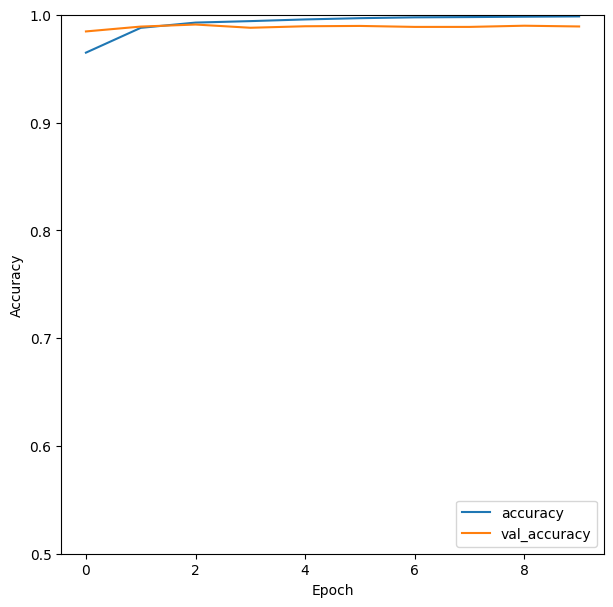

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

### 2. FA model
(1) install weights of pretrained CNN layer. This set of weights is from CNN+FCN that used backpropagation
(2) feed this CNN result into a separate set of FCN layers, which we would use FA to update.

### Layer Extraction & Building the hybrid

In [ ]:
# Extract layers
all_weights = [layer.get_weights() for layer in model.layers]

# should I also train the CNN separately?

In [ ]:
class CNN_withFA(nn.Module):
    def __init__(self, in_features, out_features=10): # self defined in_features & number of hidden layers
    # output_feature sis static bc both 10 for cifar10 and mnist
      super(CNN_withFA, self).__init__()
      self.in_features = in_features
      self.out_features = 10

      self.layer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
      self.
      # self.layer1 = nn.Sequential(
      #       nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
      #       nn.ReLU(), nn.MaxPool2d(kernel_size = 2, stride = 2))
      # self.layer2 = nn.Sequential(
      #       nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      #       nn.ReLU())
      self.layer3 = LinearFAModule(self.in_features, 100)
      self.layer4 = LinearFAModule(100, out_features)
      # self.layer2 = nn.Sequential(
      #       nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      #       nn.BatchNorm2d(64),
      #       nn.ReLU(),
      #       nn.MaxPool2d(kernel_size = 2, stride = 2))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = self.layer7(out)
        # out = self.layer8(out)
        # out = self.layer9(out)
        # out = self.layer10(out)
        # out = self.layer11(out)
        # out = self.layer12(out)
        # out = self.layer13(out)
        # out = out.reshape(out.size(0), -1)
        # out = self.fc(out)
        # out = self.fc1(out)
        # out = self.fc2(out)
        return out

In [ ]:
mnist_input_features = 784
num_epochs = 10
batch_size = 16
learning_rate = 0.005

model = CNN_withFA(mnist_input_features).to(device)

for i, layer in enumerate(model.layers):
    layer_name = layer.name
    layer_weights = layer.get_weights()
    print(f"Weights of Layer {i} ({layer_name}): {layer_weights}")

# Set weights of the CNN using pretrained weights
# for i, layer_weights in enumerate(all_weights[:-2]): # only transfer for CNN
#     if layer_weights:
#         model.layers[i].set_weights(layer_weights)



# maybe loose this part
# Now, freeze the CNN
# for layer in model.layers[:-1]:
#     layer.trainable = False

<ipython-input-18-315a784c8d12>:69: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
<ipython-input-18-315a784c8d12>:70: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)
<ipython-input-18-315a784c8d12>:71: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


AttributeError: ignored

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

### 2.  A linear FA implementation

### Train the FA Part of the model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import os

BATCH_SIZE = 32

train_loader = DataLoader(datasets.CIFAR10('./data', train=True, download=True,
                                         transform=transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.1307,), (0.3081,))
                                         ])),
                          batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.CIFAR10('./data', train=False, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ])),
                         batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 72429883.88it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.utils.data.dataloader.DataLoader

In [ ]:
# Or, construct and train the FA model, and then import its weights
model_fa = LinearFANetwork(in_features=64*64, num_layers=2, num_hidden_list=[1000, 10]).to(device)
# after the CNN, the images were upscaled from 32 to 64
optimizer_fa = torch.optim.SGD(model_fa.parameters(),
                            lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)
# define loss function
loss_crossentropy = torch.nn.CrossEntropyLoss()
# TRAINING LOOP
epochs = 5
# Plotting vessel: --> maybe change to validation accuracy later
fa_loss = []
for epoch in range(epochs):
    for idx_batch, (inputs, targets) in enumerate(train_loader):
        # flatten the inputs from square image to 1d vector
        inputs = inputs.view(BATCH_SIZE, -1)
        # wrap them into varaibles
        inputs, targets = Variable(inputs), Variable(targets)

        # get outputs from the model
        outputs_fa = model_fa(inputs.to(device))
        # calculate loss
        loss_fa = loss_crossentropy(outputs_fa, targets.to(device))

        model_fa.zero_grad()
        loss_fa.backward()
        optimizer_fa.step()

        if (idx_batch + 1) % 500 == 0: # do this every 10 batch?
            train_log = 'epoch ' + str(epoch) + ' step ' + str(idx_batch + 1) + \
                        ' loss_fa ' + str(loss_fa.item())
            fa_loss.append(loss_fa.item())
            print(train_log)

plt.plot(fa_loss)

<ipython-input-7-8754a9db8fa6>:53: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight)
<ipython-input-7-8754a9db8fa6>:54: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  torch.nn.init.kaiming_uniform(self.weight_fa)
<ipython-input-7-8754a9db8fa6>:55: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  torch.nn.init.constant(self.bias, 1)


RuntimeError: ignored

### Compare model performance

In [ ]:
#validate on CNN+FCN
#validate on CNN+FA

### Linear.py

In [ ]:
from torch.autograd import Function
from torch import nn
# already imported: import torch
# already imported: import torch.nn.functional as F

# Inherit from Function
class LinearFunction(Function):
    # Note that both forward and backward are @staticmethods
    @staticmethod
    # bias is an optional argument
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        output = input.mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return output

    # This function has only a single output, so it gets only one gradient
    @staticmethod
    def backward(ctx, grad_output):
        # This is a pattern that is very convenient - at the top of backward
        # unpack saved_tensors and initialize all gradients w.r.t. inputs to
        # None. Thanks to the fact that additional trailing Nones are
        # ignored, the return statement is simple even when the function has
        # optional inputs.
        input, weight, bias = ctx.saved_variables
        grad_input = grad_weight = grad_bias = None
        # These needs_input_grad checks are optional and there only to
        # improve efficiency. If you want to make your code simpler, you can
        # skip them. Returning gradients for inputs that don't require it is
        # not an error.

        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
        if bias is not None and ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias


class Linear(nn.Module):
    def __init__(self, input_features, output_features, bias=True):
        super(Linear, self).__init__()
        self.input_features = input_features
        self.output_features = output_features

        # nn.Parameter is a special kind of Variable, that will get
        # automatically registered as Module's parameter once it's assigned
        # as an attribute. Parameters and buffers need to be registered, or
        # they won't appear in .parameters() (doesn't apply to buffers), and
        # won't be converted when e.g. .cuda() is called. You can use
        # .register_buffer() to register buffers.
        # nn.Parameters can never be volatile and, different than Variables,
        # they require gradients by default.
        self.weight = nn.Parameter(torch.Tensor(output_features, input_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(output_features))
        else:
            # You should always register all possible parameters, but the
            # optional ones can be None if you want.
            self.register_parameter('bias', None)

        # weight initialization
        torch.nn.init.kaiming_uniform(self.weight)
        torch.nn.init.constant(self.bias, 1)

    def forward(self, input):
        # See the autograd section for explanation of what happens here.
        return LinearFunction.apply(input, self.weight, self.bias)


class LinearNetwork(nn.Module):
    def __init__(self, in_features, num_layers, num_hidden_list):
        """
        :param in_features: dimension of input features (784 for MNIST)
        :param num_layers: number of layers for feed-forward net
        :param num_hidden_list: list of integers indicating hidden nodes of each layer
        """
        super(LinearNetwork, self).__init__()
        self.in_features = in_features
        self.num_layers = num_layers
        self.num_hidden_list = num_hidden_list

        # create list of linear layers
        # first hidden layer
        self.linear = [Linear(self.in_features, self.num_hidden_list[0])]
        # append additional hidden layers to list
        for idx in range(self.num_layers - 1):
            self.linear.append(Linear(self.num_hidden_list[idx], self.num_hidden_list[idx+1]))

        # create ModuleList to make list of layers work
        self.linear = nn.ModuleList(self.linear)


    def forward(self, inputs):
        """
        forward pass, which is same for conventional feed-forward net
        :param inputs: inputs with shape [batch_size, in_features]
        :return: logit outputs from the network
        """
        # first layer
        linear1 = F.relu(self.linear[0](inputs))

        linear2 = self.linear[1](linear1)

        return linear2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch
import os

BATCH_SIZE = 32

# load mnist dataset
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True,
                                         transform=transforms.Compose([
                                             transforms.ToTensor(),
                                             transforms.Normalize((0.1307,), (0.3081,))
                                         ])),
                          batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True,
                                        transform=transforms.Compose([
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.1307,), (0.3081,))
                                        ])),
                         batch_size=BATCH_SIZE, shuffle=True)

# load feedforward dfa model
model_fa = LinearFANetwork(in_features=784, num_layers=2, num_hidden_list=[1000, 10]).to(device)

# load reference linear model
model_bp = LinearNetwork(in_features=784, num_layers=2, num_hidden_list=[1000, 10]).to(device)

# optimizers
optimizer_fa = torch.optim.SGD(model_fa.parameters(),
                            lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)
optimizer_bp = torch.optim.SGD(model_bp.parameters(),
                            lr=1e-4, momentum=0.9, weight_decay=0.001, nesterov=True)

loss_crossentropy = torch.nn.CrossEntropyLoss()

# make log file
results_path = 'bp_vs_fa_'
logger_train = open(results_path + 'train_log.txt', 'w')

# train loop
epochs = 5
# Plotting vessel: --> maybe change to validation accuracy later
fa_loss = []
bp_loss = []
for epoch in range(epochs):
    for idx_batch, (inputs, targets) in enumerate(train_loader):
        # flatten the inputs from square image to 1d vector
        inputs = inputs.view(BATCH_SIZE, -1)
        # wrap them into varaibles
        inputs, targets = Variable(inputs), Variable(targets)
        # get outputs from the model
        outputs_fa = model_fa(inputs.to(device))
        outputs_bp = model_bp(inputs.to(device))
        # calculate loss
        loss_fa = loss_crossentropy(outputs_fa, targets.to(device))
        loss_bp = loss_crossentropy(outputs_bp, targets.to(device))

        model_fa.zero_grad()
        loss_fa.backward()
        optimizer_fa.step()

        model_bp.zero_grad()
        loss_bp.backward()
        optimizer_bp.step()

        if (idx_batch + 1) % 500 == 0: # do this every 10 batch?
            train_log = 'epoch ' + str(epoch) + ' step ' + str(idx_batch + 1) + \
                        ' loss_fa ' + str(loss_fa.item()) + ' loss_bp ' + str(loss_bp.item())
            fa_loss.append(loss_fa.item())
            bp_loss.append(loss_bp.item())
            print(train_log)
            logger_train.write(train_log + '\n')

plt.plot(fa_loss)
plt.plot(bp_loss)

### Drafts

In [ ]:
# Define your CNN model
model_fa = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  # Assuming 10 classes for example
])

# Compile the model
model_fa.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model_fa.summary()

# Define a new optimizer class for Feedback Alignment
class FeedbackAlignmentOptimizer(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.001, name="FeedbackAlignmentOptimizer", **kwargs):
        super(FeedbackAlignmentOptimizer, self).__init__(name, **kwargs)
        self.learning_rate = learning_rate

    def apply_gradients(self, grads_and_vars, name=None):
        for grad, var in grads_and_vars:
            random_matrix = tf.random.normal(var.shape)
            var.assign_add(-self.learning_rate * grad * random_matrix)

# Create an instance of the custom optimizer
fa_optimizer = FeedbackAlignmentOptimizer(learning_rate=0.001)

# Compile the model with the custom optimizer
model_fa.compile(optimizer=fa_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Now, freeze the convolutional layers
for layer in model_fa.layers[:-2]:
    layer.trainable = False

# Train the model with Feedback Alignment on the fully connected layers
model_fa.fit(train_images, train_labels, epochs=5, validation_data=(test_images, test_labels))


#you need to build fc layers first, freeze the fc and train CNN, freeze CNN and train fc with new optimizer


In [ ]:
def create_random_dataset(n_in, n_out, len_samples):
    '''Creates randomly a matrix n_out x n_in which will be
       the target function to learn. Then generates
       len_samples examples which will be the training set'''
    M = np.random.randint(low=-10, high=10, size=(n_out, n_in))
    samples = []
    targets = []
    for i in range(len_samples):
        sample = np.random.randn(n_in)
        samples.append(sample)
        targets.append(np.dot(M, sample))

    return M, np.asarray(samples), np.asarray(targets)

## Using captum

In [ ]:
# setup
!pip install torchvision==0.13.0
!pip install git+https://github.com/pytorch/captum.git

import numpy as np
import json
from PIL import Image
import torch
import torch.nn.functional as F
import torchvision.models as models
import captum
from captum.attr import visualization as viz
from torchvision import transforms

# MAKE SURE WE ARE USING GPU
# This checks if GPU is available, and uses it only if so
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

In [ ]:
!wget https://mylearningsinaiml.files.wordpress.com/2018/09/mnistdata1.jpg -O number.jpg

In [ ]:
# -- Your code here -- #
conv_withfa.to(device)
# set model to eval mode
conv_withfa.eval()
# did not visualize the model

!gdown /content/mnist_classes.json -O mnist_classes.json


# Define the preprocessing pipeline for the input image
preprocess = transforms.Compose([
    transforms.Resize((28, 28)),             # resize the image to have a longer side of 256 pixels while maintaining the image ratio
    #transforms.CenterCrop(224),           # crop to size 224*224
    transforms.ToTensor(),                # convert to tensor not numpy
    transforms.Normalize(mean=[0.5], std=[0.5]), # normalize pixel values, provide mean & std for RGB channels
])


PATH_TO_LABELS = 'mnist_classes.json'
with open(PATH_TO_LABELS, 'r') as f:
    imagenet_classes = json.load(f)

def decode_preds(outputs, class_names=mnist_classes):
  # Assuming outputs is the tensor of model outputs
  softmax_outputs = F.softmax(outputs, dim=1)
  probability, predicted_class = torch.max(softmax_outputs, dim=1)

  predicted_class_labels = [class_names[str(idx)] for idx in predicted_class.cpu().numpy()]
  probability_scores = probability.cpu().numpy()

  # Print or return the results
  for label, score in zip(predicted_class_labels, probability_scores):
      print(f'\nClass: {label}, Probability: {score}')


# Function to load and preprocess the image
def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img_tensor = preprocess(img)
    img_tensor.unsqueeze_(0)  # Add a batch dimension
    return img_tensor

# -- Your code here -- #
image = load_and_preprocess_image('number.jpg').to(device)

with torch.no_grad(): # no gradient descent, perform eval
    # Pass images through the model
    outputs = conv_withfa(image)

decode_preds(outputs)

# --------------------- #

In [ ]:
def forward_func(i):
  return conv_withfa(i)
salient_object = captum.attr.Saliency(forward_func)
attributions = salient_object.attribute(image, target = torch.tensor([0]))
# type(attributions)
# attributions is of type tensor/tuple. It means each feature's gradient.
# image - your preprocessed image
# attributions - the attributions obtained from captum

# The preprocessing included normalizing the image which we need invert here
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

# Your input image to the model.
unnorm_image = inv_normalize(image)

# Display the image and the attribution
_ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(unnorm_image.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=None,
                                      show_colorbar=True, outlier_perc=2)